In [1]:
# testing pretrained model
# %pip install torch torchvision matplotlib
# %pip install lime

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torchvision.models import resnet50, densenet121
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import numpy as np
import os
import datetime

In [2]:
# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load the datasets
dataset_path = './dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print(f'Classes: {class_names}')

Classes: ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']


In [3]:
# split dataset into train and test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

labels = [label for _, label in full_dataset]
labels = np.array(labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

c:\Users\yisye\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Number of training samples: 2388
Number of testing samples: 598


In [4]:
# data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# loading Densenet121 (pretrained model for transfer learning)
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last dense block
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

num_classes = len(class_names)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.classifier.in_features, num_classes)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\yisye/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 101MB/s] 


cuda


In [7]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [9]:
# Training loop
epochs = 50
print("Training started...")

loss_train = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss = loss.item()
    loss_train.append(epoch_loss)
    
    print(f"{datetime.datetime.now().time()} Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Training started...
18:58:37.884212 Epoch 1/50, Loss: 0.1431
18:59:04.979160 Epoch 2/50, Loss: 0.1336
18:59:33.395485 Epoch 3/50, Loss: 0.0779
19:00:02.244686 Epoch 4/50, Loss: 0.0690
19:00:31.198266 Epoch 5/50, Loss: 0.0769
19:01:00.164440 Epoch 6/50, Loss: 0.0596
19:01:28.761970 Epoch 7/50, Loss: 0.0511
19:01:56.345745 Epoch 8/50, Loss: 0.0691
19:02:24.695371 Epoch 9/50, Loss: 0.0543
19:02:52.464900 Epoch 10/50, Loss: 0.0345
19:03:21.544611 Epoch 11/50, Loss: 0.0416
19:03:50.071161 Epoch 12/50, Loss: 0.0351
19:04:18.122614 Epoch 13/50, Loss: 0.0303
19:04:47.494195 Epoch 14/50, Loss: 0.0228
19:05:15.996037 Epoch 15/50, Loss: 0.0311
19:05:45.185824 Epoch 16/50, Loss: 0.0263
19:06:13.997437 Epoch 17/50, Loss: 0.0246
19:06:43.359878 Epoch 18/50, Loss: 0.0318
19:07:12.080552 Epoch 19/50, Loss: 0.0293
19:07:40.414985 Epoch 20/50, Loss: 0.0242
19:08:08.861794 Epoch 21/50, Loss: 0.0312
19:08:37.187750 Epoch 22/50, Loss: 0.0231
19:09:05.606581 Epoch 23/50, Loss: 0.0199
19:09:34.521762 Epoch 2

Text(0.5, 1.0, 'Training Loss')

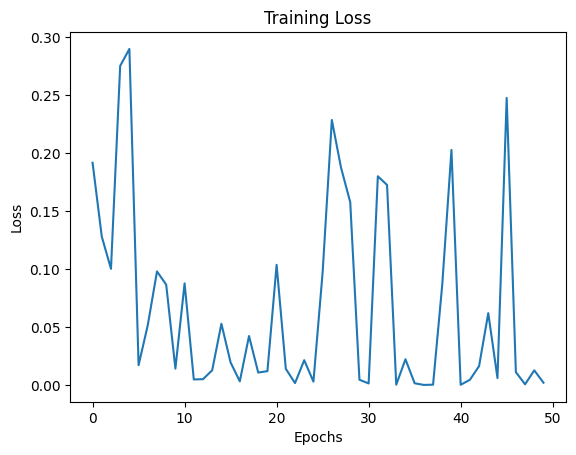

In [10]:
plt.plot(loss_train)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

In [9]:
# # Prepare Stratified K-Fold Cross-Validation
# K = 5  # Number of folds
# skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
# indices = np.arange(len(full_dataset))
# targets = np.array([full_dataset.targets[i] for i in range(len(full_dataset))])

# # Training parameters
# batch_size = 32
# epochs = 5  # Adjust based on training time

# # Store performance metrics
# fold_accuracies = []
# fold_f1_scores = []

# # K-Fold Cross-Validation loop
# for fold, (train_idx, val_idx) in enumerate(skf.split(indices, targets)):
#     print(f"\nFold {fold + 1}/{K}")

#     # Create train and validation subsets
#     train_subset = Subset(full_dataset, train_idx)
#     val_subset = Subset(full_dataset, val_idx)

#     # Create data loaders
#     train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

#     # Load ResNet50 model
#     model = models.resnet50(pretrained=True)
#     for param in model.parameters():
#         param.requires_grad = False  # Freeze pretrained layers

#     # Modify fully connected layer with dropout
#     model.fc = nn.Sequential(
#         nn.Dropout(p=0.1),
#         nn.Linear(model.fc.in_features, num_classes)
#     )

#     model = model.to(device)

#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

#     # Training loop
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

#     # Validation loop
#     model.eval()
#     correct, total = 0, 0
#     true_labels, predicted_labels = [], []

#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())

#     # Calculate metrics
#     accuracy = 100 * correct / total
#     fscore = f1_score(true_labels, predicted_labels, average='macro')

#     fold_accuracies.append(accuracy)
#     fold_f1_scores.append(fscore)

#     print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%")
#     print(f"Fold {fold + 1} F1-Score: {fscore:.4f}")

# # Print final K-Fold results
# print("\nFinal Cross-Validation Results:")
# print(f"Average Accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")
# print(f"Average F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")

In [11]:
# Validation
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Testing Accuracy: {accuracy:.2f}%')

# Calculate F1-Score (Macro for Multi-class)
fscore = f1_score(true_labels, predicted_labels, average='micro')
print(f'F1-Score: {fscore:.4f}')

# Save model
torch.save(model.state_dict(), 'densenet121_model2.pth')
print("Model saved.")

c:\Users\yisye\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Testing Accuracy: 93.14%
F1-Score: 0.9314
Model saved.


In [12]:
import scikitplot as skplt
from sklearn.metrics import classification_report

skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels, target_names=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']))

ImportError: cannot import name 'interp' from 'scipy' (c:\Users\yisye\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\__init__.py)

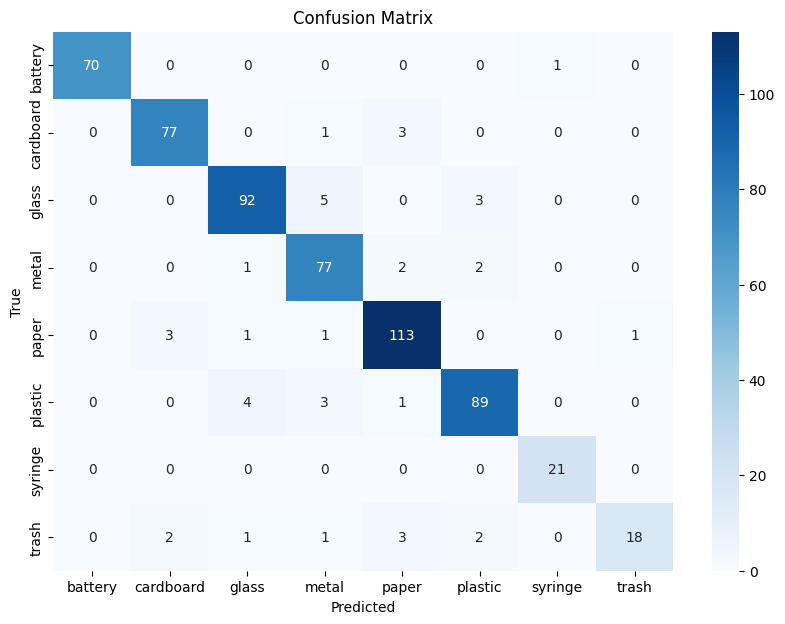

              precision    recall  f1-score   support

     battery       1.00      0.99      0.99        71
   cardboard       0.94      0.95      0.94        81
       glass       0.93      0.92      0.92       100
       metal       0.88      0.94      0.91        82
       paper       0.93      0.95      0.94       119
     plastic       0.93      0.92      0.92        97
     syringe       0.95      1.00      0.98        21
       trash       0.95      0.67      0.78        27

    accuracy                           0.93       598
   macro avg       0.94      0.92      0.92       598
weighted avg       0.93      0.93      0.93       598



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash'], yticklabels=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']))